Importation des modules

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import joblib

Importation des données

In [10]:
data = pd.read_excel('Alice_Springs_total.xlsx')
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')

data['hour'] = data.index.hour
data['day_of_year'] = data.index.dayofyear
data['month'] = data.index.month
data['year'] = data.index.year

Modèle LightGBM sur les données de Lisbon

In [11]:
# On sélectionne les variables de notre modèle
features = [
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'global_tilted_irradiance (W/m²)',
    'wind_speed_10m (km/h)',
    'cloud_cover (%)',
    'hour',
    'month',
    'day_of_year']
#global_tilted_irradiance_instant (W/m²)
# On définit la variable cible (ici la production PV normalisée)
target = 'Normalized PV power corrected'

# On définit les périodes pour les données d'entrainement, de validation et de tes
train_data = data[data['year'] <= 2018]
val_data = data[data['year'] == 2019]
test_data = data[data['year'] == 2020]

# Création des ensembles pour chaque période
X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

print(f"Taille de l'ensemble d'entraînement : {len(X_train)} échantillons")
print(f"Taille de l'ensemble de validation : {len(X_val)} échantillons")
print(f"Taille de l'ensemble de test : {len(X_test)} échantillons")

# Création et entraînement du modèle
# objective : 'regression' donne au modèle ce que l'on veut ; ici une régression c'est à dire prédire une donnée numérique
# learning_rate (taux d'apprentissage) : Il contrôle la contribution de chaque nouvel arbre au modèle final
# Une valeur petite signifie que chaque nouvel arbre corrige les erreurs des précédents arbres de manière "plus douce"
# n_estimators : le nombre d'arbre de décision à construire
# Remarque : si learning_rate est faible, alors il faut augmenter le nombre d'arbres (n_estimators)
# num_leaves : le nombre maximum de feuilles (noeuds) dans chaque arbre de décision
# random_state : permet d'avoir des résultats reproductibles

model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate= 0.005430031221811374,
    num_leaves= 203,
    max_depth= 9,
    min_child_samples= 100,
    feature_fraction= 0.800461125888655,
    bagging_fraction= 0.9012023878033328,
    bagging_freq= 3,
    n_estimators=10000,
)

# Entraînement avec early stopping SUR LE JEU DE VALIDATION (X_val, y_val)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # Ajout de l'early stopping
)


# Utilisation de la meilleure itération (déterminée par le jeu de validation) pour prédire sur le jeu de test
# On supprime les valeurs négatives (pas de sens physique)
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# Convert y_pred to a Pandas Series with the correct index
y_pred= pd.Series(y_pred.copy(), index=y_test.index)

irradiance_zero_indices = X_test[X_test['global_tilted_irradiance (W/m²)'] == 0].index
print(f"Number of time steps with zero irradiance: {len(irradiance_zero_indices)}")

y_pred[y_pred.index.isin(irradiance_zero_indices)] = 0
print("Predictions adjusted to zero for periods with zero irradiance.")

# Évaluation du modèle grâce aux indicateurs de performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# SMAPE (plus robuste que MAPE si y_test contient des zéros)
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

print(f"R² sur le jeu test : {r2:.3f}")
print(f"MAE sur le jeu test : {mae:.2f}")
print(f"MSE sur le jeu test : {mse:.2f}")
print(f"RMSE sur le jeu test : {rmse:.2f}")
print(f"SMAPE sur le jeu test : {smape:.2f} %")


# Exportation du modèle pour l'intégrer à l'application

NOM_FICHIER_MODELE = 'modele_lightGBM_Australie.pkl'

try:
    joblib.dump(model, NOM_FICHIER_MODELE)
    print("-" * 50)
    print(f"MODÈLE SAUVEGARDÉ : '{NOM_FICHIER_MODELE}'")

except Exception as e:
    print(f"Erreur lors de la sauvegarde du modèle : {e}")

Taille de l'ensemble d'entraînement : 87648 échantillons
Taille de l'ensemble de validation : 8760 échantillons
Taille de l'ensemble de test : 8784 échantillons
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.800461125888655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.800461125888655
[LightGBM] [Warning] bagging_fraction is set=0.9012023878033328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9012023878033328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.800461125888655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.800461125888655
[LightGBM] [Warning] bagging_fraction is set=0.9012023878033328, subsample=1.0 will be ignor

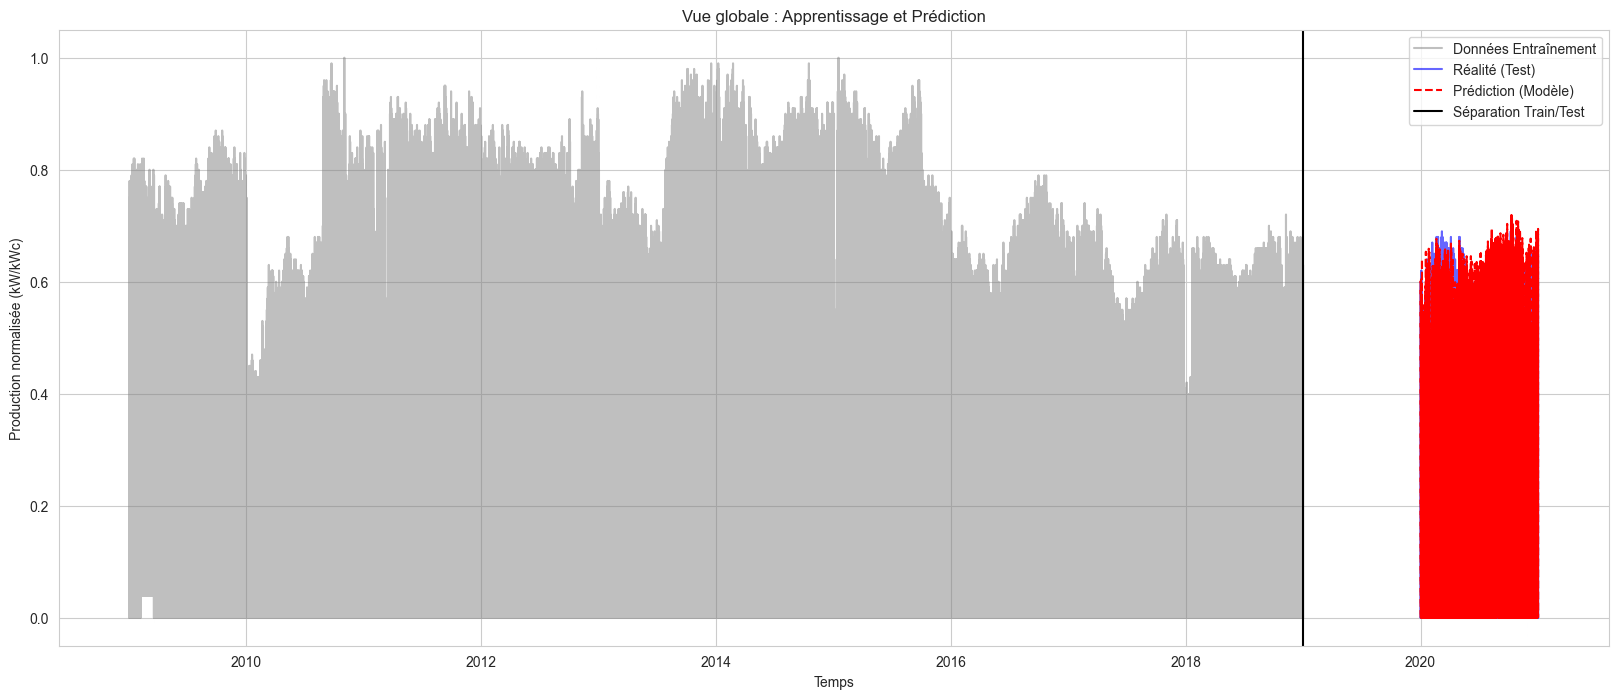

In [12]:
plt.figure(figsize=(20, 8))

# On trace la partie Entraînement (Le passé)
plt.plot(y_train.index, y_train, label='Données Entraînement', color='gray', alpha=0.5)

# On trace la partie Réalité du Test (Le futur réel)
plt.plot(y_test.index, y_test, label='Réalité (Test)', color='blue', alpha=0.6)

# On trace votre Prédiction (Le futur calculé)
plt.plot(y_test.index, y_pred, label='Prédiction (Modèle)', color='red', linestyle='--')

plt.axvline(x=y_train.index[-1], color='black', linestyle='-', label='Séparation Train/Test') # Barre verticale

plt.xlabel('Temps')
plt.ylabel('Production normalisée (kW/kWc)')
plt.title('Vue globale : Apprentissage et Prédiction')
plt.legend()
plt.show()

In [13]:
import lightgbm as lgb
import numpy as np
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# On sélectionne les variables de notre modèle
features = [
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'global_tilted_irradiance (W/m²)',
    'wind_speed_10m (km/h)',
    'cloud_cover (%)',
    'hour',
    'month',
    'day_of_year']

# On définit la variable cible (ici la production PV normalisée)
target = 'Normalized PV power corrected'

# On définit les périodes pour les données d'entrainement, de validation et de tes
train_data = data[data['year'] <= 2018]
val_data = data[data['year'] == 2019]
test_data = data[data['year'] == 2020]

# Création des ensembles pour chaque période
X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

print(f"Taille de l'ensemble d'entraînement : {len(X_train)} échantillons")
print(f"Taille de l'ensemble de validation : {len(X_val)} échantillons")
print(f"Taille de l'ensemble de test : {len(X_test)} échantillons")

# On définit les paramètres communs pour la borne inférieure, supérieure et la moyenne
COMMON_PARAMS = {
'learning_rate': 0.005430031221811374,
'num_leaves': 203,
'max_depth':9,
'min_child_samples': 100,
'feature_fraction': 0.800461125888655,
'bagging_fraction': 0.9012023878033328,
'bagging_freq': 3,
'n_estimators':10000,
}
CALLBACKS = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

# Entrainement du modèle de prédiction
print("\n--- 1. Entraînement du Modèle de Prédiction Ponctuelle (Moyenne) ---")
model_mean = lgb.LGBMRegressor(objective='regression', **COMMON_PARAMS)

model_mean.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=CALLBACKS
)

# Entrainement du modèle de la borne inférieure
print("\n--- 2. Entraînement du Modèle de Borne Inférieure (Q 2.5%) ---")
model_lower = lgb.LGBMRegressor(objective='quantile', alpha=0.025, **COMMON_PARAMS)

model_lower.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='quantile', # Métrique adaptée pour les quantiles
    callbacks=CALLBACKS
)

# Entrainement du modèle de la borne supérieure
print("\n--- 3. Entraînement du Modèle de Borne Supérieure (Q 97.5%) ---")
model_upper = lgb.LGBMRegressor(objective='quantile', alpha=0.975, **COMMON_PARAMS)

model_upper.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='quantile',
    callbacks=CALLBACKS
)

# Calcul des prédictions sur l'année de test + contraintes physiques

# Prédictions sur le jeu de test
y_pred = model_mean.predict(X_test)
y_lower = model_lower.predict(X_test)
y_upper = model_upper.predict(X_test)

# Si l'irradiance = 0 alors Production = 0
IRRADIANCE_COL = 'global_tilted_irradiance (W/m²)'
irradiance_nulle_mask = X_test[IRRADIANCE_COL] == 0

# Fonction pour appliquer les contraintes aux prédictions
def apply_physical_constraints(y_values, irradiance_mask):
    # Pas de valeurs négatives
    y_values[y_values < 0] = 0
    # Production nulle si l'irradiance est nulle
    y_values[irradiance_mask.values] = 0
    return y_values

# Application des contraintes aux trois prédictions
y_pred = apply_physical_constraints(y_pred, irradiance_nulle_mask)
y_lower = apply_physical_constraints(y_lower, irradiance_nulle_mask)
y_upper = apply_physical_constraints(y_upper, irradiance_nulle_mask)

# Assurance que l'intervalle est bien ordonné (le quantile inférieur ne doit pas être supérieur à la moyenne, etc.)
y_lower = np.minimum(y_lower, y_pred)
y_upper = np.maximum(y_upper, y_pred)

# On enregistre les 3 modèles (inférieur, supérieur, moyenne)

NOM_BASE = 'modele_lightGBM_Australie'
NOM_FICHIER_MEAN = f'{NOM_BASE}_mean.pkl'
NOM_FICHIER_LOWER = f'{NOM_BASE}_lower.pkl'
NOM_FICHIER_UPPER = f'{NOM_BASE}_upper.pkl'

try:
    joblib.dump(model_mean, NOM_FICHIER_MEAN)
    joblib.dump(model_lower, NOM_FICHIER_LOWER)
    joblib.dump(model_upper, NOM_FICHIER_UPPER)
    print("-" * 50)
    print("MODÈLES SAUVEGARDÉS pour l'intervalle de confiance à 95% :")
    print(f"  - Prédiction ponctuelle : '{NOM_FICHIER_MEAN}'")
    print(f"  - Borne inférieure (2.5%) : '{NOM_FICHIER_LOWER}'")
    print(f"  - Borne supérieure (97.5%) : '{NOM_FICHIER_UPPER}'")
    print("-" * 50)

except Exception as e:
    print(f"Erreur lors de la sauvegarde des modèles : {e}")

Taille de l'ensemble d'entraînement : 87648 échantillons
Taille de l'ensemble de validation : 8760 échantillons
Taille de l'ensemble de test : 8784 échantillons

--- 1. Entraînement du Modèle de Prédiction Ponctuelle (Moyenne) ---
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.800461125888655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.800461125888655
[LightGBM] [Warning] bagging_fraction is set=0.9012023878033328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9012023878033328
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.800461125888655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.800461125888655
[LightGBM] [Warning] b

In [14]:
# Calcul des indicateurs de performance du modèle
print("\n--- ÉVALUATION DU MODÈLE PONCTUEL (Jeu de Test) ---")
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# SMAPE (plus robuste que MAPE si y_test contient des zéros)
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

print(f"R² sur le jeu test : {r2:.3f}")
print(f"MAE sur le jeu test : {mae:.2f}")
print(f"MSE sur le jeu test : {mse:.2f}")
print(f"RMSE sur le jeu test : {rmse:.2f}")
print(f"SMAPE sur le jeu test : {smape:.2f} %")


--- ÉVALUATION DU MODÈLE PONCTUEL (Jeu de Test) ---
R² sur le jeu test : 0.904
MAE sur le jeu test : 0.04
MSE sur le jeu test : 0.01
RMSE sur le jeu test : 0.07
SMAPE sur le jeu test : 83.65 %


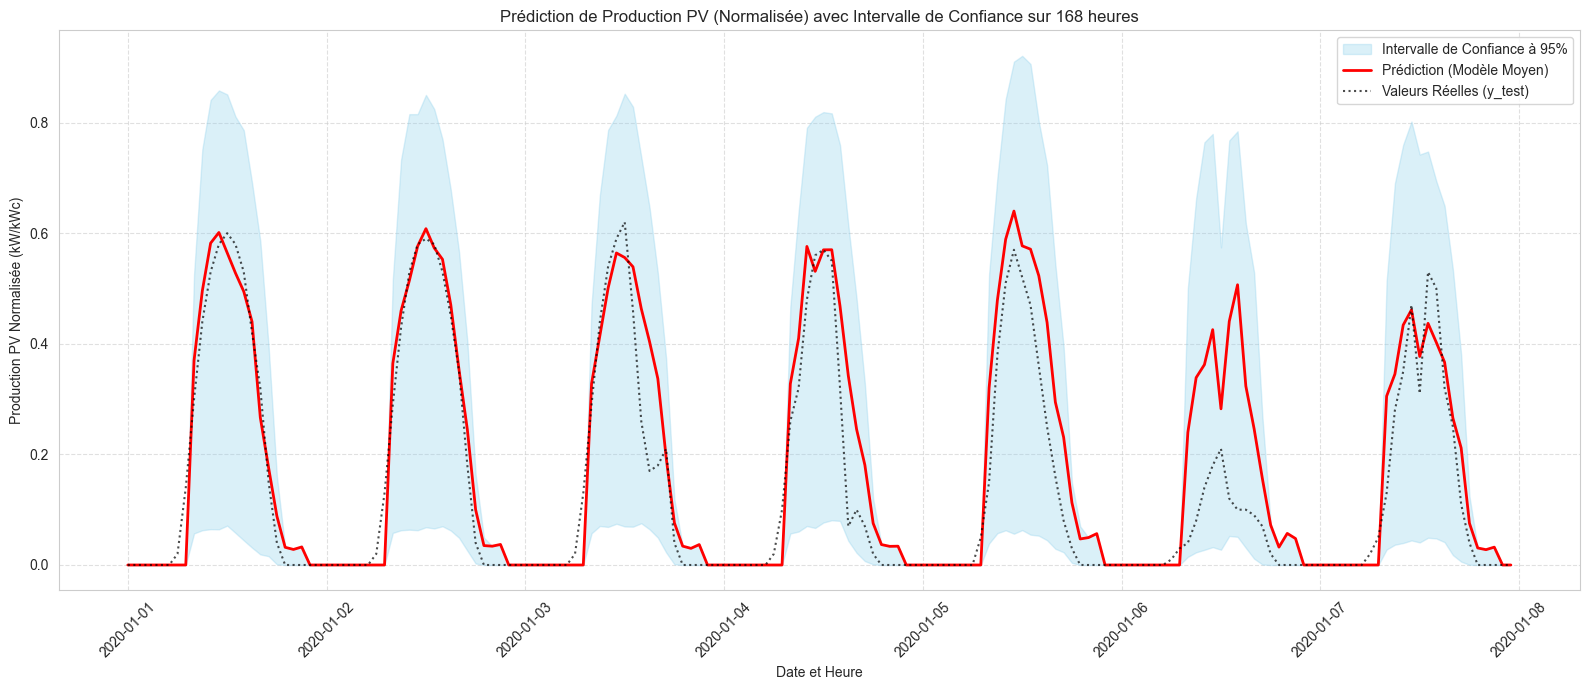

In [15]:
import matplotlib.pyplot as plt
# On crée un plot sur une partie de l'année test pour observer l'intervalle de confiance
# Le nombre d'heures à afficher (par exemple, les 7 premiers jours, soit 7*24 = 168 heures)
HEURES_A_AFFICHER = 7 * 24

# On sélectionne une sous-période pour rendre le graphique lisible
y_test_subset = y_test.head(HEURES_A_AFFICHER)
y_pred_subset = y_pred[:HEURES_A_AFFICHER]
y_lower_subset = y_lower[:HEURES_A_AFFICHER]
y_upper_subset = y_upper[:HEURES_A_AFFICHER]

plt.figure(figsize=(16, 7))

# Tracé de l'intervalle de confiance (Zone Ombrée)
plt.fill_between(
    y_test_subset.index,
    y_lower_subset,
    y_upper_subset,
    color='skyblue',
    alpha=0.3, # Transparence
    label='Intervalle de Confiance à 95%'
)

# Tracé de la Prédiction Moyenne
plt.plot(
    y_test_subset.index,
    y_pred_subset,
    label='Prédiction (Modèle Moyen)',
    color='red',
    linestyle='-',
    linewidth=2
)

# Tracé des Vraies Valeurs (pour la comparaison)
plt.plot(
    y_test_subset.index,
    y_test_subset.values,
    label='Valeurs Réelles (y_test)',
    color='black',
    linestyle=':',
    alpha=0.7
)

# Ajout des Bornes (pour voir des lignes plutôt que une zone grise)
#plt.plot(y_test_subset.index, y_lower_subset, color='blue', linestyle='--', alpha=0.5, label='Borne inférieure (Q 2.5%)')
#plt.plot(y_test_subset.index, y_upper_subset, color='green', linestyle='--', alpha=0.5, label='Borne supérieure (Q 97.5%)')


# Rendu final graphique
plt.title(f"Prédiction de Production PV (Normalisée) avec Intervalle de Confiance sur {HEURES_A_AFFICHER} heures")
plt.xlabel("Date et Heure")
plt.ylabel("Production PV Normalisée (kW/kWc)")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45) # Rotation des étiquettes de date pour éviter le chevauchement
plt.tight_layout() # Ajuste automatiquement les paramètres du subplot pour donner plus d'espace aux étiquettes
plt.show()